In [1]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))

In [3]:
library(ggplot2)
library(lattice)

#searching for input variables with zero variance (without the varible Intensity)
x <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(x, 2, var) == 0
x <- x[,!idx.zero.var]

#attache Intensity as factor
x$Intensity <- as.numeric(train.data$Intensity) -1

#Output variable
y <- train.data$VALENCE.PLEASANTNESS

#Data without predictors with a correlation index above 0.85
library(caret)

corrMatrix <- cor(x) # Access the correlation matrix (Pearson's coefficients)
highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 0.9)  # removes all indices of features which have a correlation of 0.9 or above
highlyCorrCol <- colnames(x)[highlyCorrelated]
corr.x <- x[, -which(colnames(x) %in% highlyCorrCol)]  #Data frame with only uncorrelated data

corr.data <- corr.x
corr.data$VALENCE.PLEASANTNESS <- y

In [6]:
library(randomForest)
library(tidymodels)

set.seed(1)

#Function for Cross-Validation and Predictions
fit_and_evaluate <- function(fold, formula = VALENCE.PLEASANTNESS ~ ., mtry = 10, ntree = 100, maxnodes = 30) {
    random.Forest <- randomForest::randomForest(VALENCE.PLEASANTNESS ~ ., fold, mtry = mtry, ntree = ntree, maxnodes = maxnodes)
    valid.set <- assessment(fold)
    mean((valid.set$VALENCE.PLEASANTNESS - predict(random.Forest, valid.set))^2)
}

#Cross-Validation set
validation_data <- vfold_cv(corr.data, v = 5)  

mtry <- length(corr.x) #Bagging
ntree <- seq.int(100,2000,50)
maxnodes <- seq.int(20,35)

ntree.best <- 0
maxnodes.best <- 0

## Cross-Validation of parameters 

In [7]:
cv.errors <- c()
for (i in ntree){
    cv.errors <- rbind(cv.errors, sapply(validation_data$splits, fit_and_evaluate, mtry = mtry, maxnodes = 30, ntree = i)) 
}
mean.cv.errors <- rowMeans(cv.errors)

Saving 6.67 x 6.67 in image



min. less corr. error =  471.0105

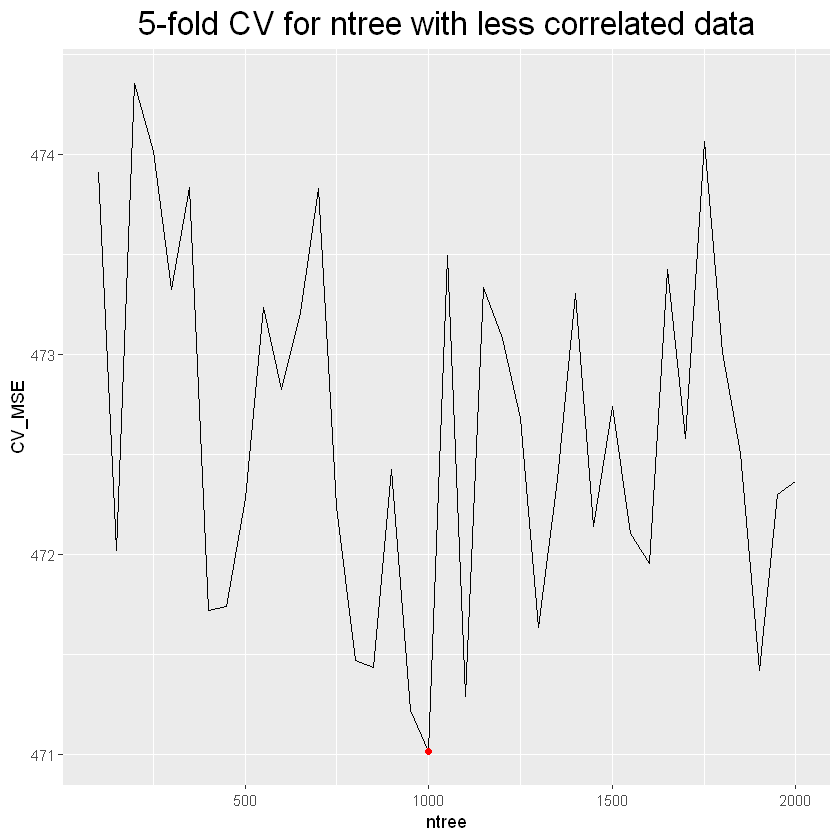

In [8]:
min <- which.min(mean.cv.errors)
ntree.best <- ntree[min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

data <- data.frame("ntree" = ntree, "CV_MSE" = mean.cv.errors)
data %>% ggplot(aes(x = ntree, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for ntree with less correlated data") + 
geom_point(aes(ntree.best, mean.cv.errors[min]), col = "red")
ggsave("../Pictures/bagging_ntree.png")

cat("min. less corr. error = ", mean.cv.errors[min])

In [9]:
cv.errors <- c()
for (i in maxnodes){
    cv.errors <- rbind(cv.errors, sapply(validation_data$splits, fit_and_evaluate, mtry = mtry, maxnodes = i, ntree = ntree.best)) 
}
mean.cv.errors <- rowMeans(cv.errors)

Saving 6.67 x 6.67 in image



min. less corr. error =  470.7193

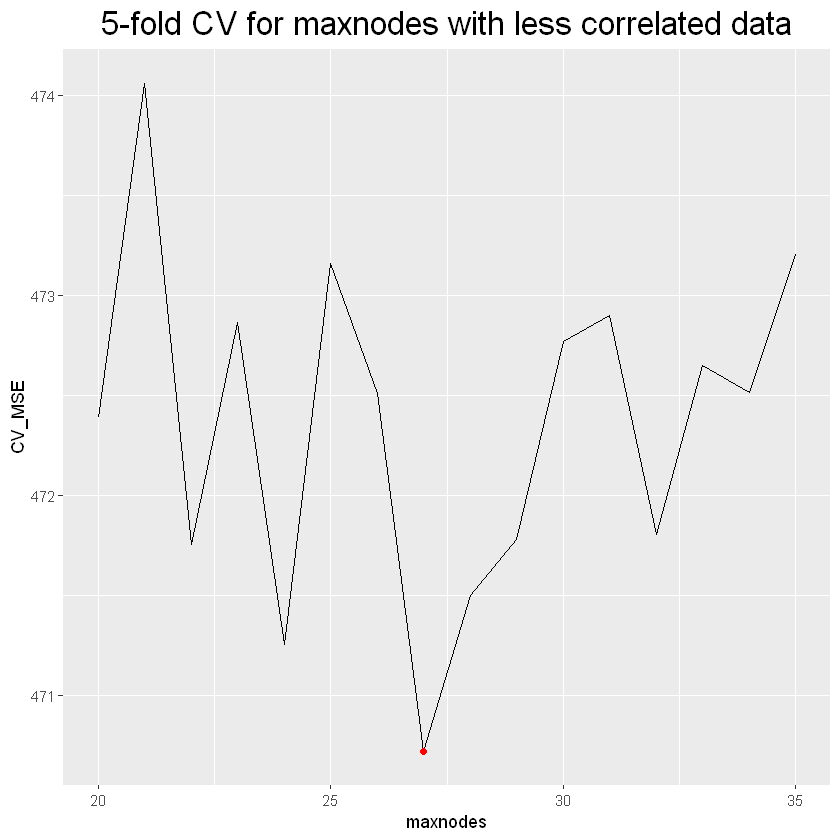

In [10]:
min <- which.min(mean.cv.errors)
maxnodes.best <- maxnodes[min]

theme_update(plot.title = element_text(hjust = 0.5, size = 20))

data <- data.frame("maxnodes" = maxnodes, "CV_MSE" = mean.cv.errors)
data %>% ggplot(aes(x = maxnodes, y = CV_MSE)) + geom_line() + ggtitle("5-fold CV for maxnodes with less correlated data") + 
geom_point(aes(maxnodes.best, mean.cv.errors[min]), col = "red")
ggsave("../Pictures/bagging_maxnodes.png")

cat("min. less corr. error = ", mean.cv.errors[min])

In [11]:
cat("The best parameters for bagging are: ntree = ", ntree.best, " and maxnodes = ", maxnodes.best)

The best parameters for bagging are: ntree =  1000  and maxnodes =  27

## Validation

In [12]:
mtry <- length(corr.x)
ntree.best <- 1000
maxnodes.best <- 27

library(randomForest)
library(tidymodels)

random.forest.validation <- function(seed){
    set.seed(seed)
    len <- length(corr.data[,1])
    idx.train <- sample(1:len, 2*len/3)
    train <- corr.data[idx.train, ]
    validation <- corr.data[-idx.train, ]
    
    r.Forest <- randomForest::randomForest(VALENCE.PLEASANTNESS ~ ., train, mtry = mtry, ntree = ntree.best, maxnodes = maxnodes.best)
    prediction <- predict(r.Forest, validation)
    mean((prediction - validation$VALENCE.PLEASANTNESS)^2)
    
}
seeds <- seq.int(100,150)
MSEs <- sapply(seeds, random.forest.validation)
mean.MSE <- mean(sqrt(MSEs))
var <- var(sqrt(MSEs))
cat("The mean RMSE is = ", mean.MSE, " and the variance is = ", var)

The mean RMSE is =  21.67612  and the variance is =  0.7114287

## Submission

In [22]:
#Random Forest Submission
set.seed(1)
#Preparation of training and test data
train <- train.data[, -c(1,2,3)]
idx.zero.var <- apply(train, 2, var) == 0

train <- train[,!idx.zero.var]
test <- test.data[,-c(1,2)]
test <- test[,!idx.zero.var]

corrMatrix <- cor(train) # Access the correlation matrix (Pearson's coefficients)
highlyCorrelated <- findCorrelation(corrMatrix, cutoff = 0.9)  # removes all indices of features which have a correlation of 0.85 or above
highlyCorrCol <- colnames(train)[highlyCorrelated]
train <- train[, -which(colnames(train) %in% highlyCorrCol)]  #Data frame with only uncorrelated data
test <- test[,-which(colnames(test) %in% highlyCorrCol)]

test$Intensity <- as.factor(test.data$Intensity)
train$Intensity <- as.factor(train.data$Intensity)

#test intensity is always at level high, so that the prediction function has a problem (cheat with adding a row that afterwards is substracted)
test <- rbind(test, train[1,])


train$VALENCE.PLEASANTNESS <- train.data$VALENCE.PLEASANTNESS

bagging <- randomForest::randomForest(VALENCE.PLEASANTNESS ~ ., train, mtry = 851, ntree = 1000, maxnodes = 27)
bagging.prediction <- predict(bagging, test)

#substracting added row
len <- length(bagging.prediction)
bagging.prediction <- bagging.prediction[-len]

In [23]:
#Creation of csv submission-file
submission <- data.frame(Id = 1:68, VALENCE.PLEASANTNESS = bagging.prediction)
write.csv(submission, file = "../Submissions/bagging.csv", row.names = FALSE)